# Intento 8 - "Mini ResNet"

## 0. Descarga del dataset

In [1]:
train_ds_path  ='.\\data\\training_set'
test_ds_path   ='.\\data\\test_set'
cat_or_dog_path='.\\data\\single_prediction\\cat_or_dog_1.jpg'


Primero, importar las librerías y paquetes

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
# Nota, algunas capas no están importadas aquí y se importan directamente en el código con tf.keras.laters.[CAPA]

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import random as rn

Fijamos seeds para poder reproducir resultados (aunque aun así a veces no lo conseguimos, probablementa haya inicializaciones que no dependan de estas seeds)

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

## 1. Construcción de la red neuronal

En este intento hemos tratado de implementar una versión reducida de la arquitectura *ResNet* que vimos en los vídeos de clase. Para ello nos hemos apoyado en el paper original ([Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)) y en la explicación adicional proporcionada en este blog: [Understanding and visualizing ResNets | by Pablo Ruiz](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

![Arquitectura de la ResNet34](imagenes/ResNet34.jpg)

Como nosotros tenemos imágenes más pequeñas y sólo dos clases, implementareos una versión reducida de la ResNet. En concreto implementaremos sólo la capa inicial (conv 7x7 y max pooling), los dos primeros bloques (entendiendo como bloque todas las cajas representadas con un color) y las capas finales (global average pooling + fully connected network)

In [4]:
frame_size = (64, 64)

En primer lugar, definimos un modelo (*ConvNormReluBlock*) que representa conjunto de 2 convoluciones de la ResNet (cada dos cajas en el diagrama), las convoluciones siempre van seguidas de una normalización y de una activación ReLU. Aunque en la segunda activación también se suma el input de dos capas más atrás, por eso dejamos esa ReLu fuera de este bloque. En la imagen, lo que está dentro de la línea azul es lo que se modela en este bloque.

![](imagenes/Bloque.jpg)

In [45]:
def ConvNormReluBlock(filters, first_stride):
        modelo = Sequential()
        pad = 'same' if first_stride == 1 else 'valid'            
        modelo.add(Conv2D(filters = filters,kernel_size = (3, 3), padding=pad, strides=first_stride))
        modelo.add(BatchNormalization())
        modelo.add(tf.keras.layers.ReLU())                
        modelo.add(Conv2D(filters = filters,kernel_size = (3, 3), padding='same', strides=1))
        modelo.add(BatchNormalization())        
        return modelo

A continuación, usando el modelo que acabamos de declarar construimos la capa (*ResNetBlock*) que representa el bloque entero de convoluciones (en el diagrama un bloque es un conjunto de 6 cajas con el mismo color). Cada bloque tiene 6 convoluciones, y cada dos convoluciones, antes de la activación, se suma el input de dos capas más atrás (*shortcut connection*). Además la primera convolución del bloque aplica un stride de 2 que reduce la dimensión 1 y 2 del input.

Nota: los *shortcut connections* entre capas con distinto número de filtros (las flechas discontinuas en la figura), requieren sumar dos tensores de diferente tamaño. En el *paper* original sugieren dos métodos, nosotros hemos usado el segundo (*projection shortcut*), auqnue hemos tenido que añadir un crop para que las dimiensiones cuadraran (en el paper original no hace falta porque las imágenes que utilizan tienen otro tamaño, y además usan un padding en algunos pasos que nosotros no).

Un bloque/capa *ResNetBlock* representaría un volumen en la siguiente representación en 3D de la *ResNet34*: 

![ResNet34](imagenes/Volumenes.jpg)


In [59]:
class ResNetBlock(tf.keras.layers.Layer):    
    
    def __init__(self, filters, first_stride):
        super(ResNetBlock, self).__init__()        
        self.first_stride = first_stride
        self.block1 = ConvNormReluBlock(filters, first_stride)
        self.projection_shortcut = Conv2D(filters = filters, kernel_size = (1, 1), strides=2)
        self.crop = tf.keras.layers.Cropping2D(cropping=((0,1),(0,1)))
        self.relu_endblock1 = tf.keras.layers.ReLU()
        self.block2 = ConvNormReluBlock(filters, 1)
        self.relu_endblock2 = tf.keras.layers.ReLU()
        self.block3 = ConvNormReluBlock(filters, 1)                
        self.last_relu = tf.keras.layers.ReLU()
    
    def call(self, input):
        out1 = self.block1(input)
        input_mod = input
        if self.first_stride == 2:
            input_mod = self.projection_shortcut(input)
            input_mod = self.crop(input_mod)
        inp2 = tf.math.add(out1,input_mod) # Shortcut connection
        inp2 = self.relu_endblock1(inp2)
        out2 = self.block2(inp2)
        inp3 = tf.math.add(out2,inp2) # Shortcut connection
        inp3 = self.relu_endblock2(inp3)
        out3 = self.block3(inp3)
        inp4 = tf.math.add(out3,inp3) # Shortcut connection
        out = self.last_relu(inp4)
        
        return out3

Por último, añadimos la capa inicial que incluye una convolución (aunque en nuestro caso como las imágenes son más pequeñas usamos un filtro de 5x5 en lugar de 7x7) con stride y un max pooling. También añadimso la capa final. En ResNet usan una capa de 1000 neuronas porque están prediciendo mil clases. Nosotros como tenemos un problema de clasificación binario, sólo tenemos una neurona. 

En nuestra "mini ResNet" solo hemos añadido dos bloques de 6 convoluciones cada uno (en lugar de los 5 que tiene la *ResNet34*). Además, en lugar de usar 64 y 128 filtros en cada bloque respectivamente, hemos usado sólo 32 y 64 filtros.

In [70]:
class MiniResNet(tf.keras.Model):

    def __init__(self):
        super(MiniResNet, self).__init__()
        self.firstconv = Conv2D(filters = 32,kernel_size = (5, 5), strides=(2,2))
        self.norm = BatchNormalization()
        self.maxpool = MaxPooling2D(pool_size = (3,3))
        self.resunit1 = ResNetBlock(32, first_stride=1) # El primer ResNetBlock no tiene stride
        self.resunit2 = ResNetBlock(64, first_stride=2)  # El segundo ResNetBlocks si aplica un stride sobre el output del bloque anterior
        self.globavgpool = GlobalAveragePooling2D()        
        self.lastlayer = Dense(units = 1, activation = "sigmoid")
    
        
        self.build(input_shape=(None, *frame_size, 3))

    def call(self, inputs):            
        
        x = self.firstconv(inputs)
        x = self.norm(x)
        x = self.maxpool(x)        
        x = self.resunit1(x)
        x = self.resunit2(x)
        x = self.globavgpool(x)        
        x = self.lastlayer(x)
        
        return x

## 2. Entrenamiento del modelo

En primer lugar instanciamos nuestro modelo y compilamos usando:
* Un optimizador Adam con learning rate del 0.001, como en el modelo base.
* Binary cross entropy como función de coste a minimizar.  

En segundo lugar, generamos los datasets de entrenamiento y test. Emplearemos un tamaño de batch de 32

In [49]:
from keras.preprocessing.image import ImageDataGenerator

batch_size=32 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(train_ds_path,
                                                     target_size=frame_size,
                                                     batch_size=batch_size,
                                                     class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(test_ds_path,
                                                   target_size=frame_size,                                                   
                                                   batch_size=batch_size,
                                                   class_mode='binary')
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience=5),
]                                                   

model = MiniResNet()
model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
                   loss = "binary_crossentropy", 
                   metrics = ["accuracy"])

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Definimos el callback y realizamos el entrenamiento con las condiciones descritas en la sección de introducción.

In [57]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience=5),
]                                                   

model = MiniResNet()
model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
                   loss = "binary_crossentropy", 
                   metrics = ["accuracy"])
history_resnet = model.fit(x=training_dataset,
                         steps_per_epoch=8000//batch_size,
                         epochs=100,
                         validation_data=testing_dataset,
                         validation_steps=2000//batch_size,
                         workers=4,
                         callbacks=callbacks)

Model: "mini_res_net_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_255 (Conv2D)          multiple                  2432      
_________________________________________________________________
batch_normalization_221 (Bat multiple                  128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling multiple                  0         
_________________________________________________________________
res_net_block_34 (ResNetBloc multiple                  56256     
_________________________________________________________________
res_net_block_35 (ResNetBloc multiple                  206784    
_________________________________________________________________
global_average_pooling2d_17  multiple                  0         
_________________________________________________________________
dense_33 (Dense)             multiple              

Ploteamos el resultado

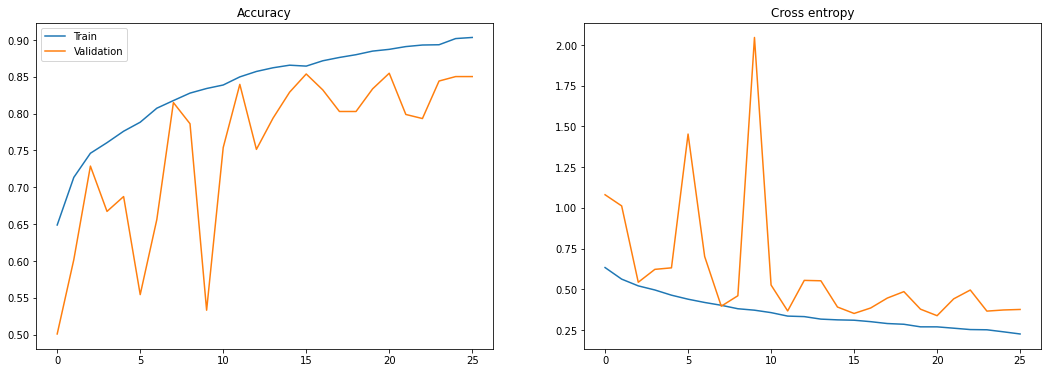

In [58]:
def plot_resultados_training(history):
    fig, axes = plt.subplots(1,2, figsize=(18,6))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].legend()
    axes[0].set_title('Accuracy')
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Cross entropy')
plot_resultados_training(history_resnet)

Como vemos, el entrenamiento se para tras no haber mejora en el valor de la cross-entropía durante 5 epochs, siendo la mejor *accuracy* en validación del **85.5%**. Es destacable también que está *accuracy* se alcanza con un modelo con ~265k parámetros, **10 veces menos** que el modelo base, por lo que es más eficiente en el entrenamiento.